In [3]:
### First, build the model ###
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, regularizers

class VAE(object):
    def __init__(self, input_shape=(28,28,1), latent_dim=2):
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        
    def kl_divergence(self, y_true, y_pred):
        mean, logvar = tf.split(y_pred, num_or_size_splits=2, axis=1)
        
        kl_loss = -0.5 * K.sum(1 + logvar - 
                              K.square(mean) - 
                              K.exp(logvar), axis=-1)
        
        return kl_loss
        
    def build_decoder(self):
        inputs = Input(shape=(self.latent_dim,))
        d1 = Dense(7 * 7 * 16, activation='relu')(inputs)
        
        reshape = Reshape(target_shape=(7,7,16))(d1)
        
        ### Now dimension = 14 x 14 x 16 ###
        conv1 = Conv2DTranspose(16, activation='relu', kernel_size=3, strides=2, padding='same')(reshape)
        ### Now dimension = 28 x 28 x 8 ###
        conv2 = Conv2DTranspose(8, activation='relu', kernel_size=3, strides=2, padding='same')(conv1)
        output = Conv2DTranspose(1, kernel_size=3, strides=1, padding='same')(conv2)
        
        decoder = Model(inputs, output, name='Decoder')
        return decoder
    
    def build_encoder(self):
        inputs = Input(shape=self.input_shape)
        ### Now dimension = 14 x 14 x 8 ###
        conv1 = Conv2D(8, kernel_size=3, strides=(2,2), activation='relu')(inputs)
        ### Now dimension = 7 x 7 x 16 ###
        conv2 = Conv2D(16, kernel_size=3, strides=(2,2), activation='relu')(conv1)
        flatten = Flatten()(conv2)
        output = Dense(self.latent_dim + self.latent_dim)(flatten)
        
        encoder = Model(inputs, output, name='Encoder')
        return encoder
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=(self.latent_dim,))
        return eps * tf.exp(logvar * 0.5) + mean
        
    def build(self):
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        
        inputs = Input(shape=self.input_shape)
        encoded = self.encoder(inputs)
        
        ### Reparameterize and decode ###
        ### z = eps * sigma + mu ###
        mean, logvar = tf.split(encoded, num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        
        decoded = self.decoder(z)
        
        ### Rename the two tensors to assign losses ###
        encoded = Lambda(lambda x : x, name='encoded_output')(encoded)
        decoded = Lambda(lambda x : x, name='decoded_output')(decoded)
        model = Model(inputs, [decoded, encoded])
        
        return model
    
model = VAE().build()
print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
Encoder (Functional)            (None, 4)            3556        input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_split_1 (TensorFlow [(None, 2), (None, 2 0           Encoder[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Mul_2 (TensorFlowOp [(None, 2)]          0           tf_op_layer_split_1[0][1]        
_______________________________________________________________________________________

In [4]:
### Then prepare the dataset ###
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()

### Normalize the dataset to [-1, 1] range ###
def normalize_data(x):
    x = (x - 127.5) / 127.5
    return x
def denormalize_data(x):
    x = x * 127.5 + 127.5
    x = x.astype(np.uint8)
    return x

X_train = normalize_data(X_train)
X_test = normalize_data(X_test)

In [ ]:
### Prepare training phases ###
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

INPUT_SHAPE = (28,28,1)
LATENT_DIM = 2
BATCH_SIZE=64
EPOCHS=1000
MODEL_CHECKPOINT = 'model_1.weights.hdf5'

vae = VAE(input_shape=INPUT_SHAPE, latent_dim=LATENT_DIM)
model = vae.build()
if(os.path.exists(MODEL_CHECKPOINT)):
    print('[*] Transfer learning from existing checkpoint ...')
    model.load_weights(MODEL_CHECKPOINT)

Y_train = {
    'decoded_output' : X_train,
    'encoded_output' : np.zeros((X_train.shape[0], LATENT_DIM * 2))
}

Y_test = {
    'decoded_output' : X_test,
    'encoded_output' : np.zeros((X_test.shape[0], LATENT_DIM * 2))
}

adam = Adam(lr=1e-3, amsgrad=True)
losses = {
    'decoded_output' : tf.keras.losses.mean_squared_error,
    'encoded_output' : vae.kl_divergence
}

def lr_decay(epochs, lr):
    decay_rate = 1 / EPOCHS
    init_lr = 1e-3 
    
    return init_lr * (1.0/(1.0 + decay_rate * epochs))

callbacks = [
    ModelCheckpoint(MODEL_CHECKPOINT, verbose=1, save_best_only=True),
    EarlyStopping(patience=15, verbose=1),
    CSVLogger('training.log.csv'),
    LearningRateScheduler(lr_decay, verbose=1)
]

model.compile(optimizer=adam, loss=losses)
model.fit(X_train, Y_train,
         callbacks=callbacks,
         validation_data=(X_test, Y_test),
         batch_size=BATCH_SIZE,
         epochs=EPOCHS)

[*] Transfer learning from existing checkpoint ...

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/1000
924/938 [============================>.] - ETA: 0s - loss: 0.5240 - decoded_output_loss: 0.4233 - encoded_output_loss: 0.1007
Epoch 00001: val_loss improved from inf to 0.28414, saving model to model_1.weights.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 0.5206 - decoded_output_loss: 0.4207 - encoded_output_loss: 0.0998 - val_loss: 0.2841 - val_decoded_output_loss: 0.2433 - val_encoded_output_loss: 0.0408

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009990009990009992.
Epoch 2/1000
925/938 [============================>.] - ETA: 0s - loss: 0.2649 - decoded_output_loss: 0.2396 - encoded_output_loss: 0.0253
Epoch 00002: val_loss improved from 0.28414 to 0.24949, saving model to model_1.weights.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 0.2647 - decoded_output_loss: 0.2395 - encoded_output_l

913/938 [============================>.] - ETA: 0s - loss: 0.2230 - decoded_output_loss: 0.2224 - encoded_output_loss: 6.7724e-04
Epoch 00016: val_loss did not improve from 0.22238
938/938 [==============================] - 2s 2ms/step - loss: 0.2231 - decoded_output_loss: 0.2224 - encoded_output_loss: 6.7723e-04 - val_loss: 0.2227 - val_decoded_output_loss: 0.2220 - val_encoded_output_loss: 6.9541e-04

Epoch 00017: LearningRateScheduler reducing learning rate to 0.000984251968503937.
Epoch 17/1000
927/938 [============================>.] - ETA: 0s - loss: 0.2229 - decoded_output_loss: 0.2222 - encoded_output_loss: 6.8632e-04
Epoch 00017: val_loss improved from 0.22238 to 0.22202, saving model to model_1.weights.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 0.2229 - decoded_output_loss: 0.2222 - encoded_output_loss: 6.8662e-04 - val_loss: 0.2220 - val_decoded_output_loss: 0.2213 - val_encoded_output_loss: 6.7921e-04

Epoch 00018: LearningRateScheduler reducing lea


Epoch 00032: LearningRateScheduler reducing learning rate to 0.0009699321047526674.
Epoch 32/1000
920/938 [============================>.] - ETA: 0s - loss: 0.2197 - decoded_output_loss: 0.2189 - encoded_output_loss: 7.9604e-04
Epoch 00032: val_loss improved from 0.21901 to 0.21892, saving model to model_1.weights.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 0.2197 - decoded_output_loss: 0.2189 - encoded_output_loss: 7.9619e-04 - val_loss: 0.2189 - val_decoded_output_loss: 0.2181 - val_encoded_output_loss: 8.0705e-04

Epoch 00033: LearningRateScheduler reducing learning rate to 0.0009689922480620155.
Epoch 33/1000
925/938 [============================>.] - ETA: 0s - loss: 0.2196 - decoded_output_loss: 0.2188 - encoded_output_loss: 8.0026e-04
Epoch 00033: val_loss did not improve from 0.21892
938/938 [==============================] - 2s 2ms/step - loss: 0.2196 - decoded_output_loss: 0.2188 - encoded_output_loss: 8.0069e-04 - val_loss: 0.2198 - val_decoded_output


Epoch 00048: LearningRateScheduler reducing learning rate to 0.0009551098376313277.
Epoch 48/1000
923/938 [============================>.] - ETA: 0s - loss: 0.2178 - decoded_output_loss: 0.2169 - encoded_output_loss: 8.8738e-04
Epoch 00048: val_loss did not improve from 0.21696
938/938 [==============================] - 2s 2ms/step - loss: 0.2178 - decoded_output_loss: 0.2169 - encoded_output_loss: 8.8659e-04 - val_loss: 0.2174 - val_decoded_output_loss: 0.2165 - val_encoded_output_loss: 8.9088e-04

Epoch 00049: LearningRateScheduler reducing learning rate to 0.0009541984732824427.
Epoch 49/1000
924/938 [============================>.] - ETA: 0s - loss: 0.2176 - decoded_output_loss: 0.2167 - encoded_output_loss: 8.9185e-04
Epoch 00049: val_loss improved from 0.21696 to 0.21689, saving model to model_1.weights.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 0.2177 - decoded_output_loss: 0.2168 - encoded_output_loss: 8.9178e-04 - val_loss: 0.2169 - val_decoded_output


Epoch 00064: LearningRateScheduler reducing learning rate to 0.0009407337723424272.
Epoch 64/1000
915/938 [============================>.] - ETA: 0s - loss: 0.2162 - decoded_output_loss: 0.2152 - encoded_output_loss: 9.6774e-04
Epoch 00064: val_loss did not improve from 0.21519
938/938 [==============================] - 2s 2ms/step - loss: 0.2162 - decoded_output_loss: 0.2152 - encoded_output_loss: 9.6764e-04 - val_loss: 0.2155 - val_decoded_output_loss: 0.2146 - val_encoded_output_loss: 9.8359e-04

Epoch 00065: LearningRateScheduler reducing learning rate to 0.0009398496240601504.
Epoch 65/1000
926/938 [============================>.] - ETA: 0s - loss: 0.2160 - decoded_output_loss: 0.2150 - encoded_output_loss: 9.7159e-04
Epoch 00065: val_loss did not improve from 0.21519
938/938 [==============================] - 2s 2ms/step - loss: 0.2160 - decoded_output_loss: 0.2151 - encoded_output_loss: 9.7146e-04 - val_loss: 0.2159 - val_decoded_output_loss: 0.2150 - val_encoded_output_loss: 9


Epoch 00080: LearningRateScheduler reducing learning rate to 0.0009267840593141798.
Epoch 80/1000
922/938 [============================>.] - ETA: 0s - loss: 0.2148 - decoded_output_loss: 0.2138 - encoded_output_loss: 0.0010
Epoch 00080: val_loss did not improve from 0.21377
938/938 [==============================] - 2s 2ms/step - loss: 0.2148 - decoded_output_loss: 0.2138 - encoded_output_loss: 0.0010 - val_loss: 0.2139 - val_decoded_output_loss: 0.2129 - val_encoded_output_loss: 0.0010

Epoch 00081: LearningRateScheduler reducing learning rate to 0.0009259259259259259.
Epoch 81/1000
931/938 [============================>.] - ETA: 0s - loss: 0.2147 - decoded_output_loss: 0.2137 - encoded_output_loss: 0.0010
Epoch 00081: val_loss improved from 0.21377 to 0.21377, saving model to model_1.weights.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 0.2147 - decoded_output_loss: 0.2137 - encoded_output_loss: 0.0010 - val_loss: 0.2138 - val_decoded_output_loss: 0.2127 - val_

921/938 [============================>.] - ETA: 0s - loss: 0.2139 - decoded_output_loss: 0.2128 - encoded_output_loss: 0.0011
Epoch 00096: val_loss did not improve from 0.21296
938/938 [==============================] - 2s 2ms/step - loss: 0.2138 - decoded_output_loss: 0.2127 - encoded_output_loss: 0.0011 - val_loss: 0.2132 - val_decoded_output_loss: 0.2121 - val_encoded_output_loss: 0.0011

Epoch 00097: LearningRateScheduler reducing learning rate to 0.0009124087591240875.
Epoch 97/1000
916/938 [============================>.] - ETA: 0s - loss: 0.2137 - decoded_output_loss: 0.2126 - encoded_output_loss: 0.0011
Epoch 00097: val_loss did not improve from 0.21296
938/938 [==============================] - 2s 2ms/step - loss: 0.2138 - decoded_output_loss: 0.2127 - encoded_output_loss: 0.0011 - val_loss: 0.2131 - val_decoded_output_loss: 0.2120 - val_encoded_output_loss: 0.0011

Epoch 00098: LearningRateScheduler reducing learning rate to 0.0009115770282588879.
Epoch 98/1000
927/938 [=====

938/938 [==============================] - 2s 2ms/step - loss: 0.2129 - decoded_output_loss: 0.2118 - encoded_output_loss: 0.0011 - val_loss: 0.2116 - val_decoded_output_loss: 0.2105 - val_encoded_output_loss: 0.0011

Epoch 00113: LearningRateScheduler reducing learning rate to 0.0008992805755395683.
Epoch 113/1000
913/938 [============================>.] - ETA: 0s - loss: 0.2128 - decoded_output_loss: 0.2117 - encoded_output_loss: 0.0011
Epoch 00113: val_loss did not improve from 0.21163
938/938 [==============================] - 2s 2ms/step - loss: 0.2128 - decoded_output_loss: 0.2117 - encoded_output_loss: 0.0011 - val_loss: 0.2119 - val_decoded_output_loss: 0.2108 - val_encoded_output_loss: 0.0011

Epoch 00114: LearningRateScheduler reducing learning rate to 0.0008984725965858042.
Epoch 114/1000
912/938 [============================>.] - ETA: 0s - loss: 0.2129 - decoded_output_loss: 0.2117 - encoded_output_loss: 0.0011
Epoch 00114: val_loss did not improve from 0.21163
938/938 [===


Epoch 00129: LearningRateScheduler reducing learning rate to 0.0008865248226950354.
Epoch 129/1000
929/938 [============================>.] - ETA: 0s - loss: 0.2120 - decoded_output_loss: 0.2108 - encoded_output_loss: 0.0012
Epoch 00129: val_loss improved from 0.21077 to 0.21070, saving model to model_1.weights.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 0.2120 - decoded_output_loss: 0.2108 - encoded_output_loss: 0.0012 - val_loss: 0.2107 - val_decoded_output_loss: 0.2095 - val_encoded_output_loss: 0.0012

Epoch 00130: LearningRateScheduler reducing learning rate to 0.0008857395925597874.
Epoch 130/1000
916/938 [============================>.] - ETA: 0s - loss: 0.2119 - decoded_output_loss: 0.2107 - encoded_output_loss: 0.0012
Epoch 00130: val_loss did not improve from 0.21070
938/938 [==============================] - 2s 2ms/step - loss: 0.2119 - decoded_output_loss: 0.2108 - encoded_output_loss: 0.0012 - val_loss: 0.2110 - val_decoded_output_loss: 0.2099 - va

922/938 [============================>.] - ETA: 0s - loss: 0.2112 - decoded_output_loss: 0.2100 - encoded_output_loss: 0.0012
Epoch 00145: val_loss did not improve from 0.20994
938/938 [==============================] - 2s 2ms/step - loss: 0.2112 - decoded_output_loss: 0.2100 - encoded_output_loss: 0.0012 - val_loss: 0.2100 - val_decoded_output_loss: 0.2088 - val_encoded_output_loss: 0.0012

Epoch 00146: LearningRateScheduler reducing learning rate to 0.0008733624454148472.
Epoch 146/1000
927/938 [============================>.] - ETA: 0s - loss: 0.2111 - decoded_output_loss: 0.2099 - encoded_output_loss: 0.0012
Epoch 00146: val_loss did not improve from 0.20994
938/938 [==============================] - 2s 2ms/step - loss: 0.2111 - decoded_output_loss: 0.2099 - encoded_output_loss: 0.0012 - val_loss: 0.2100 - val_decoded_output_loss: 0.2088 - val_encoded_output_loss: 0.0012

Epoch 00147: LearningRateScheduler reducing learning rate to 0.0008726003490401397.
Epoch 147/1000
932/938 [===

919/938 [============================>.] - ETA: 0s - loss: 0.2106 - decoded_output_loss: 0.2094 - encoded_output_loss: 0.0012
Epoch 00161: val_loss improved from 0.20944 to 0.20939, saving model to model_1.weights.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 0.2105 - decoded_output_loss: 0.2093 - encoded_output_loss: 0.0012 - val_loss: 0.2094 - val_decoded_output_loss: 0.2082 - val_encoded_output_loss: 0.0012

Epoch 00162: LearningRateScheduler reducing learning rate to 0.0008613264427217915.
Epoch 162/1000
930/938 [============================>.] - ETA: 0s - loss: 0.2105 - decoded_output_loss: 0.2093 - encoded_output_loss: 0.0012
Epoch 00162: val_loss did not improve from 0.20939
938/938 [==============================] - 2s 2ms/step - loss: 0.2105 - decoded_output_loss: 0.2093 - encoded_output_loss: 0.0012 - val_loss: 0.2097 - val_decoded_output_loss: 0.2085 - val_encoded_output_loss: 0.0012

Epoch 00163: LearningRateScheduler reducing learning rate to 0.000860

925/938 [============================>.] - ETA: 0s - loss: 0.2100 - decoded_output_loss: 0.2088 - encoded_output_loss: 0.0012
Epoch 00177: val_loss did not improve from 0.20855
938/938 [==============================] - 2s 2ms/step - loss: 0.2100 - decoded_output_loss: 0.2087 - encoded_output_loss: 0.0012 - val_loss: 0.2088 - val_decoded_output_loss: 0.2075 - val_encoded_output_loss: 0.0013

Epoch 00178: LearningRateScheduler reducing learning rate to 0.0008496176720475786.
Epoch 178/1000
938/938 [==============================] - ETA: 0s - loss: 0.2099 - decoded_output_loss: 0.2087 - encoded_output_loss: 0.0012
Epoch 00178: val_loss improved from 0.20855 to 0.20849, saving model to model_1.weights.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 0.2099 - decoded_output_loss: 0.2087 - encoded_output_loss: 0.0012 - val_loss: 0.2085 - val_decoded_output_loss: 0.2072 - val_encoded_output_loss: 0.0012

Epoch 00179: LearningRateScheduler reducing learning rate to 0.000848

922/938 [============================>.] - ETA: 0s - loss: 0.2094 - decoded_output_loss: 0.2081 - encoded_output_loss: 0.0012
Epoch 00193: val_loss did not improve from 0.20790
938/938 [==============================] - 2s 2ms/step - loss: 0.2094 - decoded_output_loss: 0.2081 - encoded_output_loss: 0.0012 - val_loss: 0.2086 - val_decoded_output_loss: 0.2073 - val_encoded_output_loss: 0.0012

Epoch 00194: LearningRateScheduler reducing learning rate to 0.0008382229673093043.
Epoch 194/1000
922/938 [============================>.] - ETA: 0s - loss: 0.2094 - decoded_output_loss: 0.2081 - encoded_output_loss: 0.0012
Epoch 00194: val_loss did not improve from 0.20790
938/938 [==============================] - 2s 2ms/step - loss: 0.2094 - decoded_output_loss: 0.2082 - encoded_output_loss: 0.0012 - val_loss: 0.2081 - val_decoded_output_loss: 0.2069 - val_encoded_output_loss: 0.0013

Epoch 00195: LearningRateScheduler reducing learning rate to 0.0008375209380234506.
Epoch 195/1000
921/938 [===

918/938 [============================>.] - ETA: 0s - loss: 0.2089 - decoded_output_loss: 0.2076 - encoded_output_loss: 0.0012
Epoch 00209: val_loss did not improve from 0.20758
938/938 [==============================] - 2s 2ms/step - loss: 0.2089 - decoded_output_loss: 0.2076 - encoded_output_loss: 0.0012 - val_loss: 0.2082 - val_decoded_output_loss: 0.2070 - val_encoded_output_loss: 0.0012

Epoch 00210: LearningRateScheduler reducing learning rate to 0.0008271298593879238.
Epoch 210/1000
937/938 [============================>.] - ETA: 0s - loss: 0.2088 - decoded_output_loss: 0.2076 - encoded_output_loss: 0.0012
Epoch 00210: val_loss did not improve from 0.20758
938/938 [==============================] - 2s 2ms/step - loss: 0.2088 - decoded_output_loss: 0.2076 - encoded_output_loss: 0.0012 - val_loss: 0.2076 - val_decoded_output_loss: 0.2064 - val_encoded_output_loss: 0.0012

Epoch 00211: LearningRateScheduler reducing learning rate to 0.0008264462809917356.
Epoch 211/1000
926/938 [===

926/938 [============================>.] - ETA: 0s - loss: 0.2084 - decoded_output_loss: 0.2072 - encoded_output_loss: 0.0013
Epoch 00225: val_loss improved from 0.20699 to 0.20689, saving model to model_1.weights.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 0.2084 - decoded_output_loss: 0.2071 - encoded_output_loss: 0.0013 - val_loss: 0.2069 - val_decoded_output_loss: 0.2056 - val_encoded_output_loss: 0.0013

Epoch 00226: LearningRateScheduler reducing learning rate to 0.0008163265306122448.
Epoch 226/1000
923/938 [============================>.] - ETA: 0s - loss: 0.2083 - decoded_output_loss: 0.2071 - encoded_output_loss: 0.0013
Epoch 00226: val_loss did not improve from 0.20689
938/938 [==============================] - 2s 2ms/step - loss: 0.2083 - decoded_output_loss: 0.2071 - encoded_output_loss: 0.0013 - val_loss: 0.2071 - val_decoded_output_loss: 0.2059 - val_encoded_output_loss: 0.0012

Epoch 00227: LearningRateScheduler reducing learning rate to 0.000815

923/938 [============================>.] - ETA: 0s - loss: 0.2078 - decoded_output_loss: 0.2066 - encoded_output_loss: 0.0013
Epoch 00241: val_loss did not improve from 0.20647
938/938 [==============================] - 2s 2ms/step - loss: 0.2078 - decoded_output_loss: 0.2066 - encoded_output_loss: 0.0013 - val_loss: 0.2069 - val_decoded_output_loss: 0.2057 - val_encoded_output_loss: 0.0012

Epoch 00242: LearningRateScheduler reducing learning rate to 0.0008058017727638999.
Epoch 242/1000
922/938 [============================>.] - ETA: 0s - loss: 0.2078 - decoded_output_loss: 0.2066 - encoded_output_loss: 0.0013
Epoch 00242: val_loss did not improve from 0.20647
938/938 [==============================] - 2s 2ms/step - loss: 0.2078 - decoded_output_loss: 0.2066 - encoded_output_loss: 0.0013 - val_loss: 0.2066 - val_decoded_output_loss: 0.2054 - val_encoded_output_loss: 0.0013

Epoch 00243: LearningRateScheduler reducing learning rate to 0.0008051529790660225.
Epoch 243/1000
919/938 [===


Epoch 00258: LearningRateScheduler reducing learning rate to 0.0007955449482895784.
Epoch 258/1000
928/938 [============================>.] - ETA: 0s - loss: 0.2074 - decoded_output_loss: 0.2061 - encoded_output_loss: 0.0013
Epoch 00258: val_loss did not improve from 0.20579
938/938 [==============================] - 2s 2ms/step - loss: 0.2073 - decoded_output_loss: 0.2061 - encoded_output_loss: 0.0013 - val_loss: 0.2060 - val_decoded_output_loss: 0.2048 - val_encoded_output_loss: 0.0013

Epoch 00259: LearningRateScheduler reducing learning rate to 0.000794912559618442.
Epoch 259/1000
910/938 [============================>.] - ETA: 0s - loss: 0.2073 - decoded_output_loss: 0.2061 - encoded_output_loss: 0.0013
Epoch 00259: val_loss did not improve from 0.20579
938/938 [==============================] - 2s 2ms/step - loss: 0.2073 - decoded_output_loss: 0.2060 - encoded_output_loss: 0.0013 - val_loss: 0.2060 - val_decoded_output_loss: 0.2047 - val_encoded_output_loss: 0.0013

Epoch 00260:

932/938 [============================>.] - ETA: 0s - loss: 0.2070 - decoded_output_loss: 0.2057 - encoded_output_loss: 0.0012
Epoch 00274: val_loss did not improve from 0.20535
938/938 [==============================] - 2s 2ms/step - loss: 0.2070 - decoded_output_loss: 0.2057 - encoded_output_loss: 0.0012 - val_loss: 0.2055 - val_decoded_output_loss: 0.2042 - val_encoded_output_loss: 0.0013

Epoch 00275: LearningRateScheduler reducing learning rate to 0.0007849293563579278.
Epoch 275/1000
925/938 [============================>.] - ETA: 0s - loss: 0.2070 - decoded_output_loss: 0.2057 - encoded_output_loss: 0.0012
Epoch 00275: val_loss did not improve from 0.20535
938/938 [==============================] - 2s 2ms/step - loss: 0.2069 - decoded_output_loss: 0.2057 - encoded_output_loss: 0.0012 - val_loss: 0.2054 - val_decoded_output_loss: 0.2041 - val_encoded_output_loss: 0.0012

Epoch 00276: LearningRateScheduler reducing learning rate to 0.0007843137254901962.
Epoch 276/1000
915/938 [===


Epoch 00291: LearningRateScheduler reducing learning rate to 0.0007751937984496124.
Epoch 291/1000
922/938 [============================>.] - ETA: 0s - loss: 0.2066 - decoded_output_loss: 0.2053 - encoded_output_loss: 0.0012
Epoch 00291: val_loss did not improve from 0.20505
938/938 [==============================] - 2s 2ms/step - loss: 0.2066 - decoded_output_loss: 0.2054 - encoded_output_loss: 0.0012 - val_loss: 0.2051 - val_decoded_output_loss: 0.2039 - val_encoded_output_loss: 0.0012

Epoch 00292: LearningRateScheduler reducing learning rate to 0.000774593338497289.
Epoch 292/1000
933/938 [============================>.] - ETA: 0s - loss: 0.2066 - decoded_output_loss: 0.2053 - encoded_output_loss: 0.0012
Epoch 00292: val_loss improved from 0.20505 to 0.20500, saving model to model_1.weights.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 0.2066 - decoded_output_loss: 0.2053 - encoded_output_loss: 0.0013 - val_loss: 0.2050 - val_decoded_output_loss: 0.2037 - val

932/938 [============================>.] - ETA: 0s - loss: 0.2062 - decoded_output_loss: 0.2049 - encoded_output_loss: 0.0012
Epoch 00307: val_loss improved from 0.20467 to 0.20450, saving model to model_1.weights.hdf5
938/938 [==============================] - 2s 2ms/step - loss: 0.2061 - decoded_output_loss: 0.2049 - encoded_output_loss: 0.0012 - val_loss: 0.2045 - val_decoded_output_loss: 0.2033 - val_encoded_output_loss: 0.0012

Epoch 00308: LearningRateScheduler reducing learning rate to 0.0007651109410864576.
Epoch 308/1000
925/938 [============================>.] - ETA: 0s - loss: 0.2062 - decoded_output_loss: 0.2049 - encoded_output_loss: 0.0012
Epoch 00308: val_loss did not improve from 0.20450
938/938 [==============================] - 2s 2ms/step - loss: 0.2061 - decoded_output_loss: 0.2049 - encoded_output_loss: 0.0012 - val_loss: 0.2046 - val_decoded_output_loss: 0.2034 - val_encoded_output_loss: 0.0012

Epoch 00309: LearningRateScheduler reducing learning rate to 0.000764

[*] Found existing model checkpoint ... 


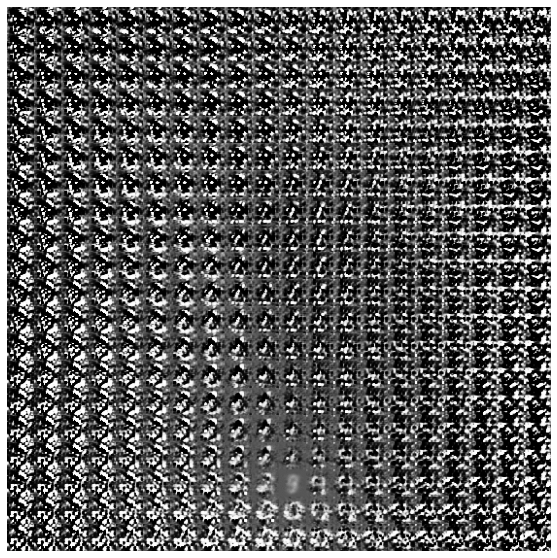

In [37]:
### Now test if the model is good ###
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

def decode(model, z, apply_sigmoid=False):
    logits = model(z)
    if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
    return logits

def sample(model, eps=None):
    if eps is None:
        eps = tf.random.normal(shape=(100, self.latent_dim))
    return decode(model, eps, apply_sigmoid=True)

def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
          z = np.array([[xi, yi]])
          x_decoded = sample(model,z)
          digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
          image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()
    
    image = denormalize_data(image)
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show() 

vae = VAE().build()
if(os.path.exists(MODEL_CHECKPOINT)):
    print('[*] Found existing model checkpoint ... ')
    vae.load_weights(MODEL_CHECKPOINT)
decoder = vae.get_layer('Decoder')
plot_latent_images(decoder, 20)